<a href="https://colab.research.google.com/github/pul35/Stock_market_forecasting/blob/main/stock_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import stock data
import time
import datetime
from datetime import date
import pandas as pd

today = date.today()
year =int(today.strftime("%Y"))
month = int(today.strftime("%m"))
day = int(today.strftime("%d"))


ticker = 'VOLCAR-B'
period1 = int(time.mktime(datetime.datetime(2021, 10, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(year, month, day, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}.ST?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

sd = pd.read_csv(query_string) #Stock data
#df.to_csv('AAPL.csv')
sd.tail()

 

,Date,Open,High,Low,Close,Adj Close,Volume
115,2022-04-13,70.400002,70.489998,66.699997,67.779999,67.779999,1761899
116,2022-04-14,68.519997,68.910004,67.239998,68.910004,68.910004,1027732
117,2022-04-19,67.459999,70.879997,66.699997,70.730003,70.730003,2654840
118,2022-04-20,69.650002,71.279999,69.000000,69.000000,69.000000,1634748
119,2022-04-21,68.750000,71.169998,65.709999,71.169998,71.169998,4347200


<Figure size 432x288 with 0 Axes>

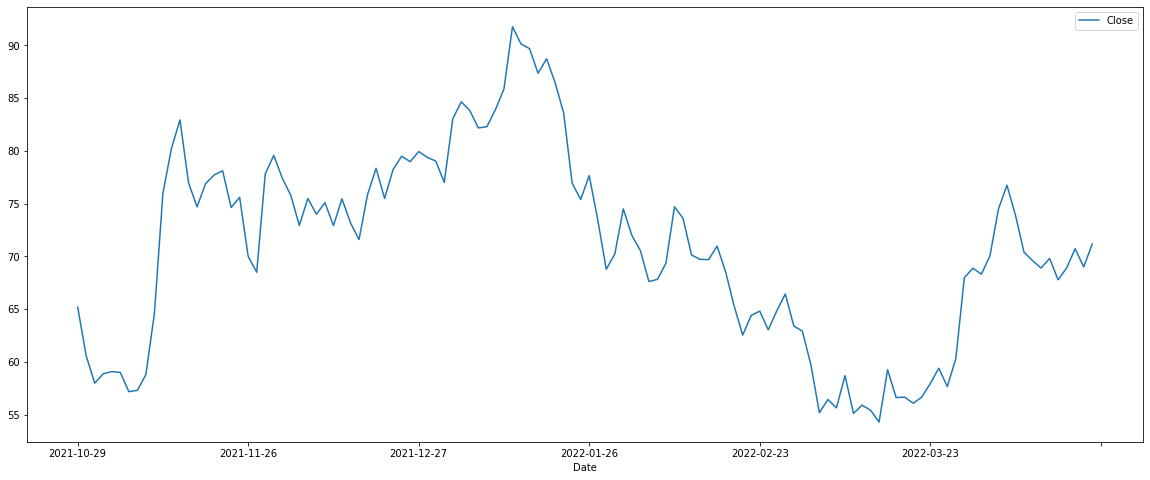

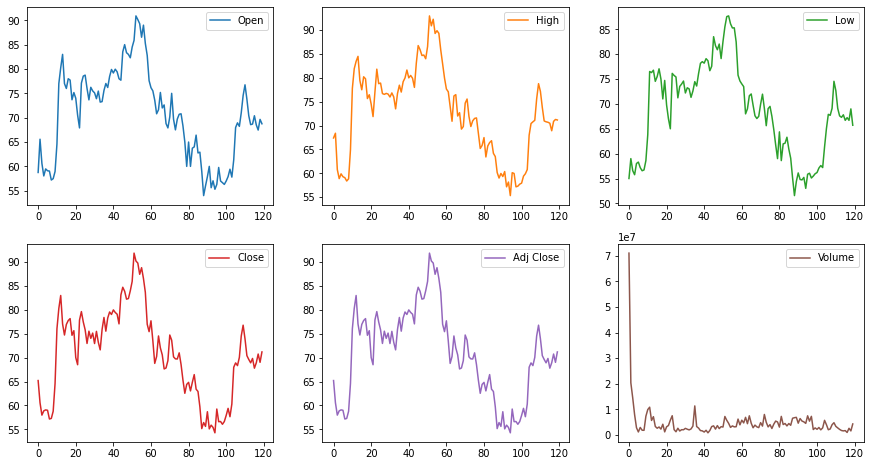

In [4]:
# Plot stock data

import matplotlib.pyplot as plt

plt.figure()
sd.plot(x = 'Date', y = 'Close', figsize=(20,8), x_compat=True)

sd.plot(subplots=True, layout=(2, 3), figsize=(15, 8), sharex=False);



In [5]:
import math

#math.asin(400/1012)

l1 = 390 + 260
l2 = 1140


math.degrees(math.atan(l1/l2))


29.690726512016813

In [6]:
# Pre processing data


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Scaling data between [0 ,1]

sd_close = sd.reset_index()['Close']

scaler = MinMaxScaler(feature_range=(0,1))
sd_close = scaler.fit_transform(np.array(sd_close).reshape(-1,1))

# Splitting data set into train data & test data

ratio = 0.70        #Splitting ratio
train_size = round(len(sd_close) * ratio)
train_data, test_data = sd_close[0:train_size, :], sd_close[train_size:len(sd_close), :]

#print(test_data.shape)

# CREATE DATA SET WITH TIMESTEP
# ex: X = t, t+1, t+3      Y = t+4

def create_dataset(data, timestep):
  data_X = []
  data_Y =[]
  for i in range(len(data)-timestep):
    a= data[i: (i+timestep),0]
    b = data[i+timestep, 0]
    data_X.append([a])
    data_Y.append(b)
  return np.array(data_X), np.array(data_Y)





In [13]:
# Generate data to feed into the model

timestep = 5
X_train, Y_train = create_dataset(train_data, timestep)
X_test, Y_test = create_dataset(test_data, timestep)

print(Y_train.shape)
print(X_train.shape)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], 1)

print(X_test.shape)
print(X_train.shape)


(79,)
(79, 1, 5)
(31, 5, 1)
(79, 5, 1)


In [26]:
# Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((timestep, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()






Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [27]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [28]:
model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 500)

Epoch 1/500
3/3 [==============================] - 2s 239ms/step - loss: 0.3142 - root_mean_squared_error: 0.5605 - val_loss: 0.0908 - val_root_mean_squared_error: 0.3013
Epoch 2/500
3/3 [==============================] - 0s 13ms/step - loss: 0.3007 - root_mean_squared_error: 0.5483 - val_loss: 0.0864 - val_root_mean_squared_error: 0.2940
Epoch 3/500
3/3 [==============================] - 0s 15ms/step - loss: 0.2877 - root_mean_squared_error: 0.5364 - val_loss: 0.0822 - val_root_mean_squared_error: 0.2868
Epoch 4/500
3/3 [==============================] - 0s 16ms/step - loss: 0.2753 - root_mean_squared_error: 0.5247 - val_loss: 0.0782 - val_root_mean_squared_error: 0.2796
Epoch 5/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2626 - root_mean_squared_error: 0.5124 - val_loss: 0.0743 - val_root_mean_squared_error: 0.2725
Epoch 6/500
3/3 [==============================] - 0s 13ms/step - loss: 0.2505 - root_mean_squared_error: 0.5005 - val_loss: 0.0704 - val_root_mean_s

In [25]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: ignored

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from utils import data_string_to_float, status_calc


# The percentage by which a stock has to beat the S&P500 to be considered a 'buy'
OUTPERFORMANCE = 10


def build_data_set():
    """
    Reads the keystats.csv file and prepares it for scikit-learn
    :return: X_train and y_train numpy arrays
    """
    training_data = pd.read_csv("keystats.csv", index_col="Date")
    training_data.dropna(axis=0, how="any", inplace=True)
    features = training_data.columns[6:]

    X_train = training_data[features].values
    # Generate the labels: '1' if a stock beats the S&P500 by more than 10%, else '0'.
    y_train = list(
        status_calc(
            training_data["stock_p_change"],
            training_data["SP500_p_change"],
            OUTPERFORMANCE,
        )
    )

    return X_train, y_train


def predict_stocks():
    X_train, y_train = build_data_set()
    # Remove the random_state parameter to generate actual predictions
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)

    # Now we get the actual data from which we want to generate predictions.
    data = pd.read_csv("forward_sample.csv", index_col="Date")
    data.dropna(axis=0, how="any", inplace=True)
    features = data.columns[6:]
    X_test = data[features].values
    z = data["Ticker"].values

    # Get the predicted tickers
    y_pred = clf.predict(X_test)
    if sum(y_pred) == 0:
        print("No stocks predicted!")
    else:
        invest_list = z[y_pred].tolist()
        print(
            f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:"
        )
        print(" ".join(invest_list))
        return invest_list


if __name__ == "__main__":
    print("Building dataset and predicting stocks...")
    predict_stocks()


ModuleNotFoundError: ignored